In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import fastai
from fastai.vision import *
import pandas as pd
import os
from shutil import copyfile


In [3]:
df_train = pd.read_csv('../train-rle.csv')

In [4]:
np.random.seed(42)
src = (ImageList.from_folder("classifier_data_512/")
                .split_by_rand_pct(0.2)
                .label_from_folder())
# Starting with image size 256
tfms = get_transforms(do_flip=True, max_rotate=15, flip_vert=False, max_lighting=0.1,
                      max_zoom=1.05, max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 symmetric_warp(magnitude=(-0.2, 0.2))])
data = (src.transform(tfms, size=256)
           .databunch(bs=64, path='.').normalize(imagenet_stats))

In [5]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [6]:
precision = Precision()
recall    = Recall()
auroc     = AUROC()
learn = cnn_learner(data, models.resnet34, metrics=[accuracy,precision,recall,auroc], model_dir=".", callback_fns=ShowGraph)
learn.loss_fn = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 3.98E-03


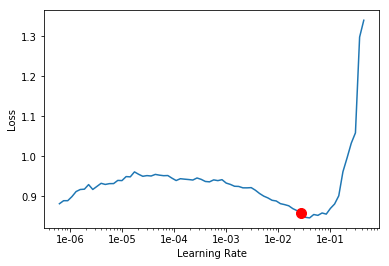

In [7]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.781600,0.570951,0.704450,0.886836,0.704156,0.764802,00:23
1,0.552224,0.429211,0.810304,0.840620,0.928484,0.808714,00:22
2,0.453699,0.395186,0.817799,0.863133,0.905868,0.851029,00:22
3,0.410302,0.384609,0.823888,0.839074,0.952934,0.862273,00:22
4,0.388411,0.358776,0.838408,0.865722,0.933985,0.876007,00:23
5,0.358361,0.347407,0.851054,0.891795,0.916870,0.886848,00:23
6,0.334988,0.353623,0.849649,0.863863,0.954156,0.888115,00:22
7,0.332545,0.345047,0.847307,0.873007,0.937042,0.888081,00:23
8,0.325335,0.341981,0.853864,0.880023,0.937042,0.890412,00:23
9,0.322799,0.340579,0.853396,0.882149,0.933374,0.891020,00:23


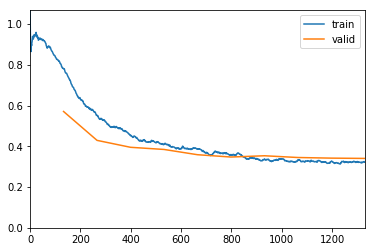

In [8]:
learn.fit_one_cycle(10,1e-3)
#learn.fit_one_cycle(1,1e-3)

In [9]:
learn.save("pneumo_256_1")


In [10]:
learn.load("pneumo_256_1")

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_512;

Valid: LabelList (2135 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_512;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): B

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.37E-06


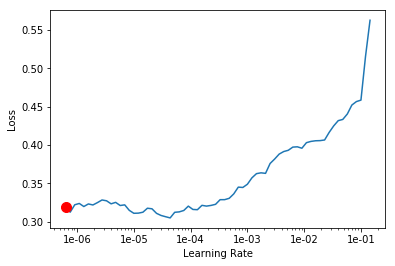

In [12]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.329229,0.339515,0.852459,0.876353,0.940098,0.893303,00:29
1,0.321968,0.328434,0.860890,0.899225,0.921760,0.899419,00:29
2,0.310849,0.342602,0.849649,0.875071,0.937653,0.889207,00:29
3,0.309588,0.331417,0.851054,0.874432,0.940709,0.900221,00:29
4,0.302705,0.443042,0.773771,0.939071,0.753667,0.884676,00:29
5,0.276675,0.324321,0.858080,0.902233,0.913814,0.911467,00:29
6,0.273411,0.422380,0.832318,0.830403,0.981663,0.913918,00:29
7,0.251392,0.320719,0.856206,0.926235,0.882641,0.919765,00:29
8,0.226019,0.337407,0.847307,0.925878,0.870416,0.912306,00:29
9,0.221951,0.420239,0.848244,0.849680,0.974328,0.921810,00:29


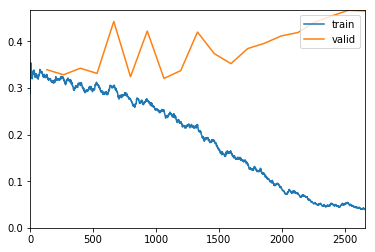

In [13]:
#learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-5))
lr = [3e-3/100, 3e-3/20, 3e-3/10]
learn.fit_one_cycle(20, lr, wd=1e-7)
#learn.fit_one_cycle(1, lr, wd=1e-7)

In [14]:
learn.save("pneumo_256_2")

In [15]:
learn.load("pneumo_256_2")

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_512;

Valid: LabelList (2135 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_512;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): B

In [16]:
# Starting with image size 512
data = (src.transform(tfms, size=512)
           .databunch(bs=32, path='.').normalize(imagenet_stats))

In [17]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 4.79E-05


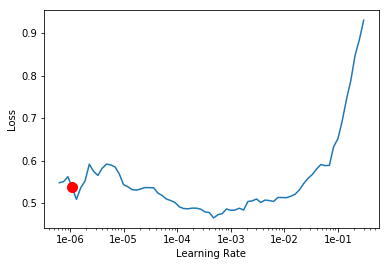

In [18]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.250317,0.328658,0.874473,0.899533,0.941320,0.915828,01:37
1,0.320437,0.319018,0.875410,0.890091,0.955379,0.906804,01:37
2,0.384300,1.038098,0.790632,0.788732,0.992665,0.841081,01:37
3,0.324302,0.701446,0.639813,0.953927,0.556846,0.864623,01:37
4,0.320513,0.435624,0.834192,0.828381,0.988386,0.913920,01:37
5,0.307053,0.302836,0.877752,0.900408,0.944988,0.915955,01:37
6,0.270159,0.285983,0.880094,0.929639,0.912592,0.932033,01:37
7,0.214967,0.266832,0.879625,0.907747,0.938264,0.935696,01:36
8,0.194388,0.271991,0.886183,0.906597,0.949266,0.936364,01:37
9,0.196348,0.273521,0.886183,0.906597,0.949266,0.938039,01:36


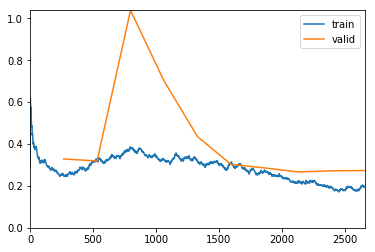

In [19]:
#learn.fit_one_cycle(4, 1e-3)
learn.fit_one_cycle(10, slice(3e-3), wd=5e-6)
#learn.fit_one_cycle(1, slice(3e-3), wd=5e-6)

In [20]:
learn.save("pneumo_512_1")

In [21]:
learn.unfreeze()
learn = learn.clip_grad();

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.186058,0.272444,0.888993,0.909783,0.949266,0.937736,01:41
1,0.191927,0.292741,0.880562,0.891218,0.961491,0.937642,01:40
2,0.173377,0.297978,0.884778,0.896237,0.960880,0.934709,01:41
3,0.185160,0.331340,0.876815,0.880754,0.970660,0.931527,01:41
4,0.179391,0.331122,0.878220,0.884358,0.967604,0.933577,01:41
5,0.177379,0.299569,0.888993,0.913172,0.944988,0.933642,01:41
6,0.162496,0.310841,0.886651,0.906651,0.949878,0.930792,01:41
7,0.154715,0.335306,0.876347,0.887571,0.960269,0.926814,01:42
8,0.153026,0.393903,0.867447,0.874377,0.965770,0.925366,01:41
9,0.160861,0.413476,0.872131,0.877562,0.968215,0.919941,01:41


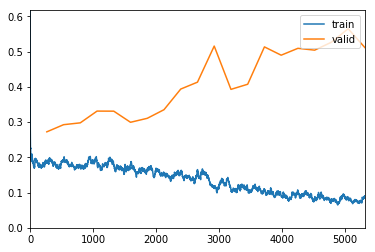

In [22]:
lr = [1e-3/200, 1e-3/20, 1e-3/10]
learn.fit_one_cycle(20, lr)
#learn.fit_one_cycle(1, lr)
#learn.fit_one_cycle(5, slice(1e-6))

In [23]:
learn.save("pneumo_512_2")

In [24]:
learn.load("pneumo_512_2")

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_512;

Valid: LabelList (2135 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_512;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): B

In [34]:
learn.load("pneumo_512_1")

Learner(data=ImageDataBunch;

Train: LabelList (8540 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_512;

Valid: LabelList (2135 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
no_disease,no_disease,no_disease,no_disease,no_disease
Path: classifier_data_512;

Test: LabelList (1372 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: classifier_data_512, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dila

In [35]:
sample_df = pd.read_csv('../sample_submission.csv')
sample_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6067.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6214.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6177.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6655.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6359.151787519...,-1


In [36]:
learn.data.add_test(ImageList.from_df(sample_df,'../data512/',folder='test',suffix='.png'))

In [37]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)
cls_pred = F.softmax(preds,1).argmax(1).cpu().numpy()

In [38]:
paths = list(map(str,list(learn.data.test_ds.x.items)))
all_test_paths = [p.split('/')[-1][:-4] for p in paths]

df_preds = pd.DataFrame()
df_preds['test_paths'] = all_test_paths
df_preds['class_pred'] = cls_pred

df_preds.set_index('test_paths',inplace=True)

In [39]:
df_preds.head()

,class_pred
test_paths,
1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,1
1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,1
1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,0
1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,1
1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,1


In [40]:
no_dis_idx = df_preds[df_preds.class_pred==1].index
print(len(no_dis_idx))

1116


In [41]:
sub = pd.read_csv('new_aug.csv',index_col=['ImageId'])
sub.head(25)
sub.fillna(value=' -1',inplace=True)
sub.head()


,EncodedPixels
ImageId,
1.2.276.0.7230010.3.1.4.8323329.6067.1517875195.915618,-1
1.2.276.0.7230010.3.1.4.8323329.6214.1517875197.83920,-1
1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733,562270 4 1019 6 1006 23 997 30 991 34 989 35 9...
1.2.276.0.7230010.3.1.4.8323329.6655.1517875199.413686,-1
1.2.276.0.7230010.3.1.4.8323329.6359.1517875197.803699,-1


In [42]:
sub.loc[no_dis_idx] = ' -1'


In [43]:
sub.to_csv('sub_classifier_correction.csv')

In [ ]:
learn.interpret